NOTES : 

- Single dataset doens't work at 
    - movie plot
    - spatial decay fit


- Add errorbars for delta_rho / rho by using error in rho

In [2]:
# Imports 
import numpy as np
import pandas as pd
import therpy as tp
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import ipywidgets
import warnings
warnings.filterwarnings("ignore")
import scipy.interpolate
from IPython.display import display, Javascript
import os
import shutil

def getNotebookName():
    display(Javascript('IPython.notebook.kernel.execute("theNotebook = " + "\'"+IPython.notebook.notebook_name+"\'");'))
    return theNotebook

cst = tp.cst()
twopi = 2 * np.pi
kHz = 1e3 * cst.h

In [3]:
# Constants 
import_params = ['ExpansionTime','SideGreenEvap','WaitBox',
               'IREvap','HeatTime','ShakeWait', 'HeatCycles',
               'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime',
               'SeqMode']

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=800, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )

fontsize = 15

In [4]:
# Function 
def movie_pad(data, xpad=True, ypad=True, xshift=False, yshift=False):
    x, y, z = data
    if xpad: x = np.concatenate([x, [x[-1] + np.diff(x)[-1]]])
    if ypad: y = np.concatenate([y, [y[-1] + np.diff(y)[-1]]])
    return (x, y, z)

# Load Data from Images

In [4820]:
df_all = pd.DataFrame()

In [4821]:
# Relevant Parameters 
x_var_name = ['BoxShakeFreq', 'BoxShakeAmp', 'ShakingCycles','HeatCycles']
x_var_label = [r'$\nu$ (Hz)', 'Amplitude (V)', 'Cycles (#)','Heat Cycles (#)']
usei = 0
x_var_name, x_var_label = x_var_name[usei], x_var_label[usei]
image_use = 'A'

In [4822]:
# Import from Clipboard 
df_all = tp.images_from_clipboard(df=df_all, x=x_var_name, params=import_params, 
                                  image_func=tp.Hybrid_Image, download=image_use, display=True)

Updating the local database...
Done

Total Number of Shots 22, Images 22


,time,image,A,B,S,download,ExpansionTime,SideGreenEvap,WaitBox,IREvap,HeatTime,ShakeWait,HeatCycles,ShakingCycles,BoxShakeFreq,BoxShakeAmp,BoxShakeTime,SeqMode,x
name,,,,,,,,,,,,,,,,,,,
12-01-2017_20_29_46_TopA,0.000000,Image object,True,False,False,True,2000.0,0.5,0.5,0.5,145.0,3.0,145.0,0.0,185.0,0.3,0.0,None,185.0
12-01-2017_20_30_41_TopA,0.916667,Image object,True,False,False,True,2000.0,0.5,0.5,0.5,145.0,3.0,145.0,0.0,185.0,0.3,0.0,None,185.0
12-01-2017_20_31_35_TopA,1.816667,Image object,True,False,False,True,2000.0,0.5,0.5,0.5,145.0,3.0,145.0,0.0,185.0,0.3,0.0,None,185.0


In [4823]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1183, center_y = 1376, fudge=1.75, width=800, height=800, subsample=3, 
                  xsec_extension='linear', xsec_slice_width=3, xsec_fit_range=1.1, radial_selection=0.75,)}

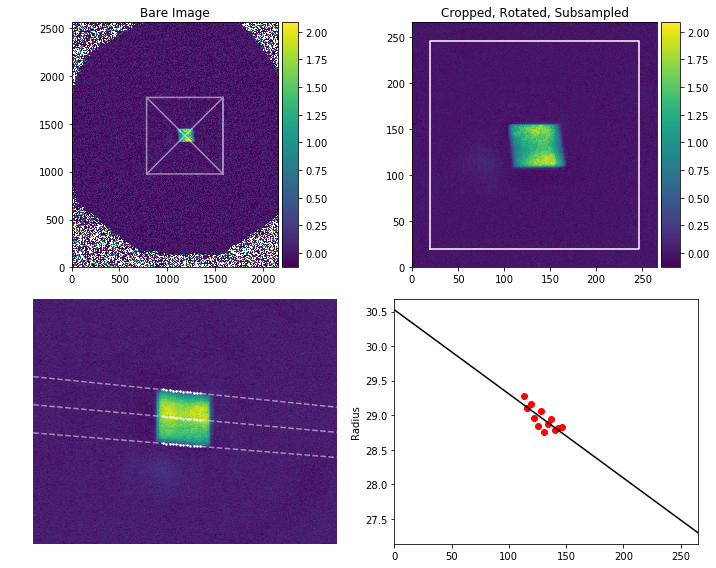

In [4824]:
# Verify Settings 

# Apply to all Images 
for n,r in df_all.iterrows(): r.image.set(**settings)
    
# Function to plot the restults 
def temp(test=np.random.randint(0, df_all.shape[0])):
    r = df_all.iloc[test]
    ax = plt.subplots(nrows=2, ncols=2, figsize=[10,8])[1].flatten()
    r.image.plot_crop(ax=ax[0:2])
    r.image.xsec.infoplot(axs=ax[2:4])
    plt.tight_layout()
    plt.show()

if df_all.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_all.shape[0]-1))

In [4825]:
# Start Saving Folder 
savefig = ipywidgets.Checkbox(value=True, description='Save Figs')
display(savefig)
folder_name = df_all.iloc[0].name[0:17] + 'BoxShaking'
suffix = os.path.join(folder_name, '')
os.makedirs(folder_name, exist_ok=True)
suffix_samples = os.path.join(folder_name, 'Samples','')
os.makedirs(os.path.join(folder_name, 'Samples'), exist_ok=True)
suffix

'12-01-2017_20_29_BoxShaking\\'

In [4826]:
# Define backgrounds 
background_parameter = 'ShakingCycles'
background_value = 0
df_all['bg'] = df_all[background_parameter] == background_value


Total Images 22 ==> Good 20, Bad 2


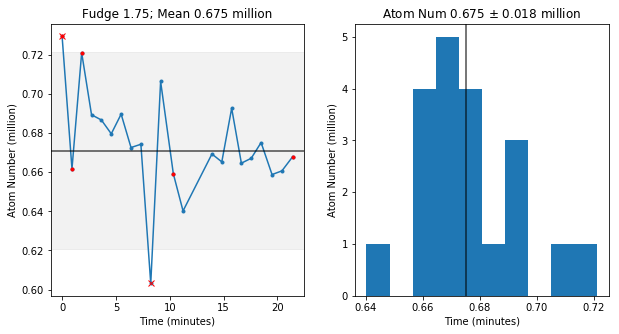

In [4827]:
# Atom Number Filter 
df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image)]
ax = tp.atom_num_filter(df=df_all, keep=0.075, offset=0.0, display=True, plot=True)
# ax[0].set(ylim=[0.3,None])
ax[0].plot(df_all.loc[df_all['bg'], 'time'], df_all.loc[df_all['bg'], 'total_atoms']/1e6, 'r.')
if savefig.value: plt.savefig(suffix + 'AtomNumbersScatter.pdf')
df = df_all[df_all.use]

[ 130.   140.   150.   160.   162.5  165.   167.5  170.   172.5  175.
  177.5  180.   182.5  185.   190.   200.   210. ]


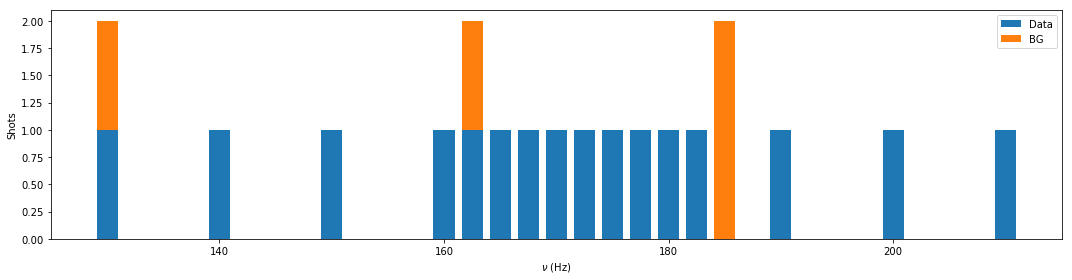

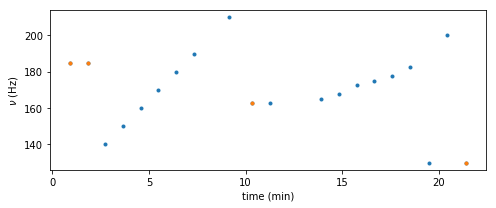

In [4828]:
# Dataset Explorer 
def dataset_counter(df, bg_param='bg', bg_value=True, x='x', plot=False, ax=None, xlabel='x'):
    '''
    count the occurances of various x data points and bg points 
    '''
    # Count number of images 
    unique_x = np.unique(df[x])
    data_counts = np.array([np.sum(df[x][df[bg_param] != bg_value] == xi) for xi in unique_x])
    bg_counts = np.array([np.sum(df[x][df[bg_param] == bg_value] == xi) for xi in unique_x])
    dataset_counter = [unique_x, data_counts, bg_counts]
    
    # Plot
    if plot: 
        ax = plt.subplots(figsize=[15,4])[1] if (ax is None) else ax
        width = np.min(np.diff(dataset_counter[0]))*0.75 if (len(dataset_counter[0]) > 1) else 1
        ax.bar(dataset_counter[0], dataset_counter[1], width, label='Data')
        ax.bar(dataset_counter[0], dataset_counter[2], width, bottom=dataset_counter[1], label='BG')
        ax.legend()
        ax.set(xlabel = xlabel, ylabel='Shots')
        plt.tight_layout()
    
    return dataset_counter, ax

ds_counter, ax = dataset_counter(df=df, plot=True, xlabel=x_var_label)
if savefig.value: ax.figure.savefig(suffix + 'DatasetCounter_vsX.pdf')
print(np.unique(df.x.values))
plt.figure(figsize = [7, 3])
plt.plot(df.time, df.x, '.')
bgi = df[background_parameter] == background_value
plt.plot(df.time[bgi], df.x[bgi], '.')
plt.xlabel('time (min)')
plt.ylabel(x_var_label)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'DatasetCounter_vsTime.pdf')

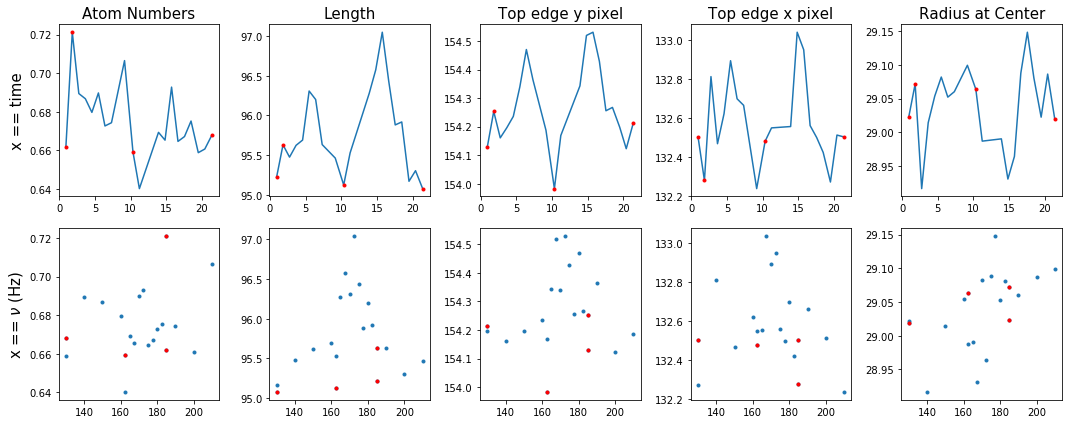

In [4829]:
# Box Length and Center 
df['nz_raw'] = [im.nz for im in tqdm(df.image)]
df['pz_raw'] = [tp.Curve(x = nz.x, y = np.arange(len(nz.x))) for nz in df['nz_raw']]
df['xsec_raw'] = [im.xsec for im in df.image]
guess_ = [-45e-6, 45e-6, 5e-6, 5e-6]
df['box_fit'] = [tp.curve_fit(tp.erf_box, guess_ + [nz.maxy, nz.maxy/1e3], *nz.data, ) for nz in df['nz_raw']]
df['length'] = [f[1] - f[0] for f in df['box_fit']]
df['top_ypixel'] = [r['pz_raw'](r['box_fit'].fv[1]) for n,r in df.iterrows()]
df['top_xpixel'] = [r['xsec_raw'].get_center(r['top_ypixel']) for n,r in df.iterrows()]
df['bottom_ypixel'] = [r['pz_raw'](r['box_fit'].fv[0]) for n,r in df.iterrows()]
df['bottom_xpixel'] = [r['xsec_raw'].get_center(r['bottom_ypixel']) for n,r in df.iterrows()]
df['center_ypixel'] = [r['pz_raw']((r['box_fit'].fv[0] + r['box_fit'].fv[1])/2) for n,r in df.iterrows()]
df['center_xpixel'] = [r['xsec_raw'].get_center(r['center_ypixel']) for n,r in df.iterrows()]
df['center_radius'] = [r['xsec_raw'].get_radius(r['center_ypixel']) for n,r in df.iterrows()]
df['nz_fixed'] = [tp.Curve(x = r.nz_raw.x, y = r.nz_raw.y - r.box_fit(amp=0), xscale=1e-6, yscale=1e18) for n,r in df.iterrows()]
df['nz_integral'] = [np.trapz(c.y, c.x) for c in df['nz_fixed']]

# Plot test 
ax = plt.subplots(ncols=5, nrows=2, figsize=[15, 6])[1].flatten()
bgi = df[background_parameter] == background_value

ax[0].plot(df['time'], df['total_atoms']/1e6)
ax[1].plot(df['time'], df['length']*1e6)
ax[2].plot(df['time'], df['top_ypixel'])
ax[3].plot(df['time'], df['top_xpixel'])
ax[4].plot(df['time'], df['center_radius'])

ax[0].plot(df.loc[bgi, 'time'], df.loc[bgi, 'total_atoms']/1e6, 'r.')
ax[1].plot(df.loc[bgi, 'time'], df.loc[bgi, 'length']*1e6, 'r.')
ax[2].plot(df.loc[bgi, 'time'], df.loc[bgi, 'top_ypixel'], 'r.')
ax[3].plot(df.loc[bgi, 'time'], df.loc[bgi, 'top_xpixel'], 'r.')
ax[4].plot(df.loc[bgi, 'time'], df.loc[bgi, 'center_radius'], 'r.')

ax[5].plot(df['x'], df['total_atoms']/1e6, '.')
ax[6].plot(df['x'], df['length']*1e6, '.')
ax[7].plot(df['x'], df['top_ypixel'], '.')
ax[8].plot(df['x'], df['top_xpixel'], '.')
ax[9].plot(df['x'], df['center_radius'], '.')

ax[5].plot(df.loc[bgi, 'x'], df.loc[bgi, 'total_atoms']/1e6, 'r.')
ax[6].plot(df.loc[bgi, 'x'], df.loc[bgi, 'length']*1e6, 'r.')
ax[7].plot(df.loc[bgi, 'x'], df.loc[bgi, 'top_ypixel'], 'r.')
ax[8].plot(df.loc[bgi, 'x'], df.loc[bgi, 'top_xpixel'], 'r.')
ax[9].plot(df.loc[bgi, 'x'], df.loc[bgi, 'center_radius'], 'r.')

ax[0].set_title('Atom Numbers', fontsize=15)
ax[1].set_title('Length', fontsize=15)
ax[2].set_title('Top edge y pixel', fontsize=15)
ax[3].set_title('Top edge x pixel', fontsize=15)
ax[4].set_title('Radius at Center', fontsize=15)
ax[0].set_ylabel(r'x == time', fontsize=15)
ax[5].set_ylabel(r'x == {}'.format(x_var_label), fontsize=15)

plt.tight_layout()

if savefig.value: plt.savefig(suffix + 'DatasetQuality.pdf')

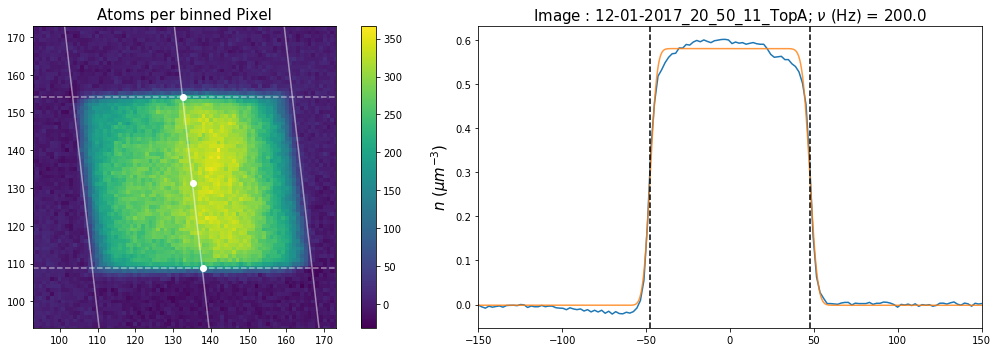

In [4830]:
# Test box fit 
size = 80
test = 0
def temp(test=np.random.randint(df.shape[0])):
    r = df.iloc[test]
    roi = tp.get_roi(r.image.app, width=size, height=size)
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    plt.sca(ax[0])
    plt.imshow(r.image.app)
    plt.colorbar()
    plt.title('Atoms per binned Pixel', fontsize=15)
    plt.plot(r.xsec_raw.get_center(r.xsec_raw.z), r.xsec_raw.z, 'w-', alpha=0.5)
    plt.plot(r.xsec_raw.get_left(r.xsec_raw.z), r.xsec_raw.z, 'w-', alpha=0.5)
    plt.plot(r.xsec_raw.get_right(r.xsec_raw.z), r.xsec_raw.z, 'w-', alpha=0.5)
    plt.axhline(r.top_ypixel, c='w', alpha=0.5, linestyle='--')
    plt.axhline(r.bottom_ypixel, c='w', alpha=0.5, linestyle='--')
    plt.plot([r.top_xpixel, r.bottom_xpixel, r.center_xpixel], [r.top_ypixel, r.bottom_ypixel, r.center_ypixel], 'ow')
    ax[0].set(xlim=[roi[1].start, roi[1].stop], ylim=[roi[0].start, roi[0].stop])
    ax[1].plot(*r.nz_raw.plotdata)
    ax[1].plot(r.box_fit.xp * 1e6, r.box_fit(r.box_fit.xp) / 1e18, alpha=0.8)
    ax[1].axvline(r.box_fit[0]*1e6, c='k', linestyle='--',)
    ax[1].axvline(r.box_fit[1]*1e6, c='k', linestyle='--',)
    ax[1].set(xlim=[-150, 150])
    image_kind = 'BG' if r[background_parameter] == background_value else 'Image'
    ax[1].set_title('{} : {}; {} = {}'.format(image_kind, r.name, x_var_label, r.x), fontsize=15)
    ax[1].set_ylabel(r'$n$ $(\mu m^{-3})$', fontsize=15)
    plt.tight_layout()
    if savefig.value: plt.savefig(suffix_samples + 'BoxFitsSamples_{}_{}.pdf'.format(r.x, r.name))
    plt.show()
if df.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df.shape[0]-1))

In [4831]:
# IMPORTANT SETTINGS 
shared_background = True 
proper_center = 'center' # top or center or bottom or none 
zero_z = 'center' # where to put the zero for z top, bottom, center 

In [4832]:
# Begin df_data and allocate images 
threshold_image_num = 1

# use dataset with enough images only
if shared_background == False:
    xlist = [x for i, x in enumerate(ds_counter[0]) 
             if (ds_counter[1][i] >= threshold_image_num) and (ds_counter[2][i] >= threshold_image_num)]
elif shared_background == True:
    xlist = [x for i, x in enumerate(ds_counter[0]) 
             if (ds_counter[1][i] >= threshold_image_num) and ds_counter[2].sum() >= threshold_image_num]
df_data = pd.DataFrame(index = xlist)

# Compute things 
df_data['data_ind'] = [(df.x == x) & (~ df['bg']) for x in df_data.index.values]
df_data['# data'] = [np.sum(t) for t in df_data['data_ind']]
if shared_background:
    df_data['bg_ind'] = [df['bg'] for x in df_data.index.values]
else:
    df_data['bg_ind'] = [df['bg'] & (df.x == x) for x in df_data.index.values]
df_data['# bg'] = [np.sum(t) for t in df_data['bg_ind']]
df_data['length'] = [np.mean(df.loc[ind,'length']) for ind in df_data['bg_ind']]
df_data['freq'] = [df.loc[ind,'BoxShakeFreq'].iloc[0] for ind in df_data['data_ind']]
df_data['cycles'] = [df.loc[ind,'ShakingCycles'].iloc[0] for ind in df_data['data_ind']]

# Start dict_data 
dict_data = {}

In [4833]:
# Calculate proper n(z) for each item in df 

# calculate proper length and density rescaling factor 
df['proper_length'] = [np.mean(df.loc[df_data.loc[r.x, 'bg_ind'], 'length']) 
                       if (r.x in xlist) else np.mean(df.loc[df.bg, 'length']) 
                       for n,r in df.iterrows()]
df['proper_nrescale'] = [np.mean(df.loc[df_data.loc[r.x, 'bg_ind'], 'nz_integral']) / r['nz_integral']
                       if (r.x in xlist) else np.mean(df.loc[df.bg, 'nz_integral']) / r['nz_integral']
                       for n,r in df.iterrows()]
        
# where to put zero of z 
if zero_z == 'bottom': df['subtract_z'] = - df['proper_length'] / 2
elif zero_z == 'top': df['subtract_z'] = df['proper_length'] / 2 
else: df['subtract_z'] = 0

# calculate nz using proper center and zero of z and proper density rescaling 
default_z = (np.arange(df.iloc[0].nz_raw.x.size) - np.mean(df.loc[df.bg, 'center_ypixel'])) * df.iloc[0].image.pixel_binned
if proper_center == 'top':
    df['nz'] = [tp.Curve(r.nz_fixed.x - (r.box_fit[1] - r.proper_length/2) - r.subtract_z, 
                         r.nz_fixed.y * r.proper_nrescale) for n,r in df.iterrows()]
elif proper_center == 'bottom':
    df['nz'] = [tp.Curve(r.nz_fixed.x - (r.box_fit[0] + r.proper_length/2) - r.subtract_z, 
                         r.nz_fixed.y * r.proper_nrescale) for n,r in df.iterrows()]
elif proper_center == 'center':
    df['nz'] = [tp.Curve(r.nz_fixed.x - (r.box_fit[0] + r.box_fit[1])/2 - r.subtract_z, 
                         r.nz_fixed.y * r.proper_nrescale) for n,r in df.iterrows()]
else:
    df['nz'] = [tp.Curve(default_z - r.subtract_z, 
                         r.nz_fixed.y * r.proper_nrescale) for n,r in df.iterrows()]



In [4834]:
# Calculate dn and dn/n 
def concat_curves(cs):
    xs = np.concatenate([c.x for c in cs])
    ys = np.concatenate([c.y for c in cs])
    c_concat = tp.Curve(xs, ys).sortbyx()
    c = c_concat.binbyx(step = np.diff(cs[0].x)[0])
    return (c_concat, c)

df_data['nz data all'] = [list(df.loc[r.data_ind, 'nz']) for x,r in df_data.iterrows()]
df_data['nz bg all'] = [list(df.loc[r.bg_ind, 'nz']) for x,r in df_data.iterrows()]
df_data['nz data'] = [concat_curves(cs)[1] for cs in df_data['nz data all']]
df_data['nz bg'] = [concat_curves(cs)[1] for cs in df_data['nz bg all']]
df_data['box fit bg'] = [tp.curve_fit(tp.erf_box, [-45e-6, 45e-6, 5e-6, 5e-6, c.maxy, c.maxy/1e3], *c.data) for c in df_data['nz bg']]

df_data['dn']   = [tp.Curve(y = r['nz data'](r['nz bg'].x) - r['nz bg'].y, 
                   x = r['nz bg'].x, xscale = 1e-6, yscale=r['box fit bg']['amp']*1e-2)
                   for x,r in df_data.iterrows()]
df_data['dn/n'] = [tp.Curve(y = (r['nz data'](r['nz bg'].x) - r['nz bg'].y) / r['nz bg'].y, 
                   x = r['nz bg'].x, xscale = 1e-6, yscale=1e-2)
                   for x,r in df_data.iterrows()]

In [4835]:
# Calculate 2d dn == centered at the center of the image 
width = 180e-6 
pixel = df.iloc[0].image.pixel_binned 
size_pixels = int(width / pixel / 2)
x = np.arange(-size_pixels, size_pixels, 1)
y = x.copy()

# Compute shifted app 
def temp(r):
    y_ = (r['nz'].x + r['subtract_z']) / pixel
    x_ = np.arange(r.image.app.shape[1]) - r['center_xpixel']
    interp = scipy.interpolate.interp2d(x_, y_, r.image.app * r.proper_nrescale, kind='linear')
    return interp(x, y)
df['app_shifted'] = [temp(r) for n, r in df.iterrows()]

# Compute 2d dn
df_data['2d dn'] = [np.mean(df.loc[r.data_ind, 'app_shifted']) - np.mean(df.loc[r.bg_ind, 'app_shifted']) 
                    for x,r in df_data.iterrows()]


In [4836]:
# Calculate Box Characteristics 
box_char = pd.DataFrame()
box_char['fudge'] = [df.image.iloc[0].fudge]
box_char['length (um)'] = np.mean(df.loc[df.bg, 'length']) * 1e6
box_char['length (um) error'] = np.std(df.loc[df.bg, 'length']) * 1e6
box_char['radius (um)'] = np.mean(df.loc[df.bg, 'center_radius']) * df.image.iloc[0].pixel_binned * 1e6
box_char['radius (um) error'] = np.std(df.loc[df.bg, 'center_radius']) * df.image.iloc[0].pixel_binned * 1e6
box_char['atom num (million)'] = np.mean(df.loc[df.bg, 'total_atoms']) / 1e6
box_char['atom num (million) error'] = np.std(df.loc[df.bg, 'total_atoms']) / 1e6
box_char['n (um^-3)'] = box_char['atom num (million)'] * 1e6 / (np.pi * box_char['radius (um)']**2 * box_char['length (um)'])
box_char['n (um^-3) error'] = box_char['atom num (million) error'] * 1e6 / (np.pi * box_char['radius (um)']**2 * box_char['length (um)'])
box_char['EF (kHz)'] = cst.n2EFHz(box_char['n (um^-3)'] * 1e18) / 1e3
box_char['EF (kHz) error'] = 2/3 * cst.n2EFHz(box_char['n (um^-3)'] * 1e18) / 1e3 * box_char['n (um^-3) error'] / box_char['n (um^-3)']
if savefig.value: box_char.to_excel(suffix + 'box_characteristics.xlsx')
box_char

,fudge,length (um),length (um) error,radius (um),radius (um) error,atom num (million),atom num (million) error,n (um^-3),n (um^-3) error,EF (kHz),EF (kHz) error
0,1.75,95.262591,0.217879,60.993257,0.049563,0.677525,0.025416,0.608541,0.022828,9.166419,0.229239


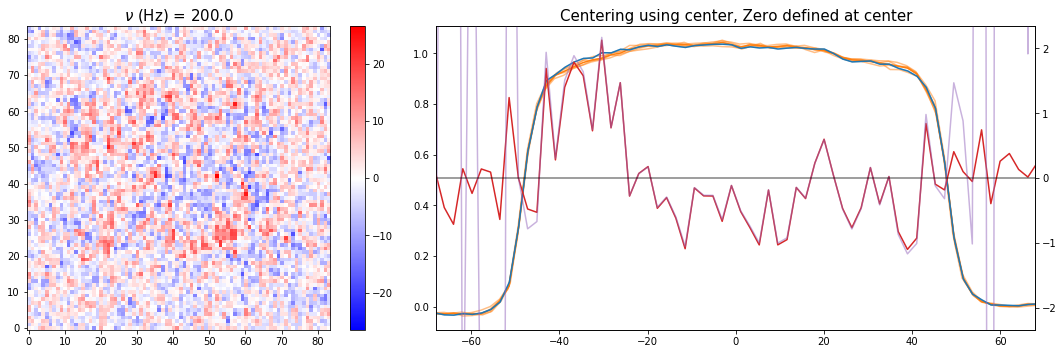

In [4837]:
# Plot Samples 
Lum = np.mean(df.length)*1e6
plot_zlim = np.array([0 - 20, Lum + 20])
if zero_z == 'center': plot_zlim -= Lum/2 
elif zero_z == 'top': plot_zlim -= Lum
def temp(test=np.random.randint(0, df_data.shape[0])): 
    r = df_data.iloc[test]
    fig = plt.figure(figsize=[15, 5])
    # Plot Image
    plt.subplot2grid((1,5),(0,0), colspan = 2)
    app = r['2d dn']
    plt.imshow(app, origin=0, clim=[-np.max(np.abs(app)), np.max(np.abs(app))], cmap='bwr')
    plt.title("{} = {}".format(x_var_label, r.name), fontsize=15)
    plt.colorbar()
    # Plot n(z) 
    ax = plt.subplot2grid((1,5),(0,2), colspan = 3)
    for n in r['nz bg all']:
        plt.plot(n.x*1e6, n.y/r['box fit bg']['amp'], 'C1-', alpha=2/len(r['nz bg all']))
    plt.plot(r['nz bg'].x*1e6, r['nz bg'].y / r['box fit bg']['amp'], 'C1-')
    for n in r['nz data all']:
        plt.plot(n.x*1e6, n.y/r['box fit bg']['amp'], 'C0-', alpha=0.2)
    plt.plot(r['nz data'].x*1e6, r['nz data'].y / r['box fit bg']['amp'], 'C0-')
    plt.xlim(plot_zlim)
    plt.title('Centering using {}, Zero defined at {}'.format(proper_center, zero_z), fontsize=15)
    ax = plt.twinx(ax)
    ax.plot(*r['dn'].plotdata, 'C3')
    ax.plot(*r['dn/n'].plotdata, 'C4', alpha=0.5)
    ax.axhline(0, c='k', alpha=0.5)
    lim = np.nanmax(np.abs(r['dn'].plotdata[1]))* 1.1
    ax.set(ylim = [-lim, lim], xlim=plot_zlim)
    plt.tight_layout()
    if savefig.value: plt.savefig(suffix_samples + 'InsituSoundWaves_{}.pdf'.format(r.name))
    plt.show()
if df_data.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_data.shape[0]-1))

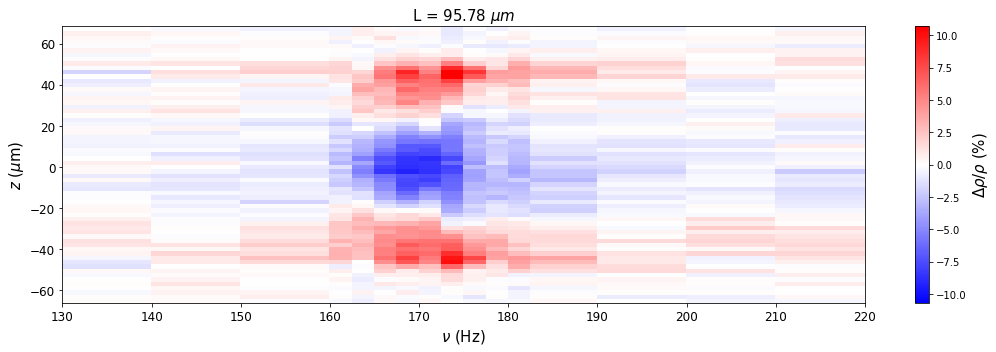

In [4838]:
# Movies 
movie = np.array([(r.dn.trim(plot_zlim * 1e-6).y) / r['box fit bg']['amp'] * 100 for x,r in df_data.iterrows()]).T
movie = [df_data.index.values, df_data.iloc[0]['dn'].trim(plot_zlim * 1e-6).x * 1e6, movie]
if savefig.value: pd.DataFrame(movie[2], index=movie[1], columns=movie[0]).to_excel(suffix + '2d_movie.xlsx')

# Plots 
clim_movie = np.max(np.abs(movie[2])) * 0.9
fig = plt.figure(figsize=[15, 5])
plt.pcolor(*movie_pad(movie), cmap='bwr', vmin=-clim_movie, vmax=clim_movie, linewidth=0)
plt.ylabel(r'$z$ ($\mu$m)', fontsize=15)
plt.xlabel(x_var_label, fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(Lum), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'$\Delta \rho / \rho$ (%)', fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'SonogramMovie_bwr.pdf')

In [4839]:
# Specialized Plots == 3 column - 2d rho_0, rho, delta_rho ; 2 column - 1d rho_0, rho, delta_rho  
# r = df_data.loc[450]
# a1 = df[r['bg_ind']].iloc[0].image.app
# a2 = df[r['data_ind']].iloc[0].image.app
# a3 = r['2d dn']
# roi = tp.get_roi(a1, width=a3.shape[1], height=a3.shape[0])

# fig, ax = plt.subplots(ncols=3, figsize=[12,4])
# for a in ax: a.set_axis_off()
# plt.sca(ax[2])
# plt.imshow(a3, origin=0, cmap='bwr')
# plt.title(r'$\Delta \rho = \rho - \rho_0$', fontsize=15)

# plt.sca(ax[0])
# plt.imshow(a1[roi], origin=0, cmap='viridis')
# plt.title(r'$\rho_{0}$ : Background Density', fontsize=15)

# plt.sca(ax[1])
# plt.imshow(a2[roi], origin=0, cmap='viridis')
# plt.title(r'$\rho$ : After Shaking', fontsize=15)

# plt.tight_layout()
# plt.savefig('Sample_SoundDemo_v1_{}.pdf'.format(r.name))
# plt.show()

# fig, ax = plt.subplots(ncols=2, figsize=[12,4])
# for a in ax: 
#     a.set(xlim=plot_zlim)
#     a.set_xlabel(r'z ($\mu m$)', fontsize=15)
# plt.sca(ax[0])
# plt.plot(r['nz bg'].x * 1e6, r['nz bg'].y / 1e18)
# plt.plot(r['nz data'].x * 1e6, r['nz data'].y / 1e18)
# plt.ylabel(r'$\rho$ ($\mu m^{-3}$)', fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

# plt.sca(ax[1])
# plt.plot(*r['dn'].plotdata)
# plt.ylabel(r'$\Delta \rho / \rho_0$ (%)', fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

# plt.tight_layout()
# plt.savefig('Sample_SoundDemo_v2_{}.pdf'.format(r.name))

In [4840]:
# # Specialized Plots == Bunch of 2d delta_rho in a single row & Bunch of 1d delta_rho in column 

# freqs = [78, 100, 150, 190, 300, 400,] 
# freqs = [500, 600, 750, 850, 1100]
# fig, ax = plt.subplots(ncols=len(freqs), figsize=[2.5 * len(freqs), 2.5])
# for f,a in zip(freqs,ax): 
#     a.set_axis_off()
#     plt.sca(a)
#     plt.imshow(df_data.loc[f,'2d dn'], origin=0, cmap='bwr', clim=[-30, 30])
#     a.set_title(r'{} Hz'.format(f))
# plt.subplots_adjust(wspace=0)
# # plt.savefig('Sample_SoundDemo_v3.pdf')
# plt.show()


# freqs = [500, 750, 1100][::-1]
# shift = np.arange(len(freqs))[::-1]
# fig, ax = plt.subplots(figsize=[5,6])
# for f,s in zip(freqs[::-1], shift):
#     ax.plot(df_data.loc[f, 'dn'].plotdata[0], df_data.loc[f, 'dn'].plotdata[1] + s*10, 'C{}'.format(s), label='{} Hz'.format(f))
#     ax.axhline(s*10, color='C{}'.format(s), alpha=0.5, linestyle='--')
# ax.set(xlim=[0,100], ylim=[None, 29])
# plt.xlabel(r'z ($\mu$m)', fontsize=15)
# plt.ylabel(r'$\Delta \rho / \rho$ (%)', fontsize=15)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
# plt.legend(fontsize=13)
# # plt.savefig('Sample_SoundDemo_v4.pdf')


# Fourier Components 

In [4841]:
# Used Functions 

def discrete_modes_v1(x, L=1, phase=0, a0=0, grad=0, a1=0, a2=0, 
                      a3=0, a4=0, a5=0, a6=0, a7=0, a8=0, a9=0, a10=0, a11=0, a12=0, 
                      a13=0, a14=0, a15=0, a16=0, a17=0, a18=0, a19=0, a20=0,):
    '''Common L and phase (cos), separate amplitudes: upto 20 modes'''
    y = a0 + grad * x 
    y += a1 * np.cos(1 * np.pi/L * x - phase)
    y += a2 * np.cos(2 * np.pi/L * x - phase)
    y += a3 * np.cos(3 * np.pi/L * x - phase)
    y += a4 * np.cos(4 * np.pi/L * x - phase)
    y += a5 * np.cos(5 * np.pi/L * x - phase)
    y += a6 * np.cos(6 * np.pi/L * x - phase)
    y += a7 * np.cos(7 * np.pi/L * x - phase)
    y += a8 * np.cos(8 * np.pi/L * x - phase)
    y += a9 * np.cos(9 * np.pi/L * x - phase)
    y += a10 * np.cos(10 * np.pi/L * x - phase)
    y += a11 * np.cos(11 * np.pi/L * x - phase)
    y += a12 * np.cos(12 * np.pi/L * x - phase)
    y += a13 * np.cos(13 * np.pi/L * x - phase)
    y += a14 * np.cos(14 * np.pi/L * x - phase)
    y += a15 * np.cos(15 * np.pi/L * x - phase)
    y += a16 * np.cos(16 * np.pi/L * x - phase)
    y += a17 * np.cos(17 * np.pi/L * x - phase)
    y += a18 * np.cos(18 * np.pi/L * x - phase)
    y += a19 * np.cos(19 * np.pi/L * x - phase)
    y += a20 * np.cos(20 * np.pi/L * x - phase)
    return y

def discrete_modes_v2(x, L=1, a0=0, grad=0, a1=0, p1=0, 
                   a2=0, p2=0, a3=0, p3=0, a4=0, p4=0, a5=0, p5=0, 
                   a6=0, p6=0, a7=0, p7=0, a8=0, p8=0, a9=0, p9=0, a10=0, p10=0, 
                   a11=0, p11=0, a12=0, p12=0, a13=0, p13=0, a14=0, p14=0, a15=0, 
                   p15=0, a16=0, p16=0, a17=0, p17=0, a18=0, p18=0, a19=0, p19=0, a20=0, p20=0):
    '''Common L, separate amplitudes and phases (cos): upto 20 modes'''
    y = a0 + grad * x 
    y += a1 * np.cos(1 * np.pi/L * x - p1)
    y += a2 * np.cos(2 * np.pi/L * x - p2)
    y += a3 * np.cos(3 * np.pi/L * x - p3)
    y += a4 * np.cos(4 * np.pi/L * x - p4)
    y += a5 * np.cos(5 * np.pi/L * x - p5)
    y += a6 * np.cos(6 * np.pi/L * x - p6)
    y += a7 * np.cos(7 * np.pi/L * x - p7)
    y += a8 * np.cos(8 * np.pi/L * x - p8)
    y += a9 * np.cos(9 * np.pi/L * x - p9)
    y += a10 * np.cos(10 * np.pi/L * x - p10)
    y += a11 * np.cos(11 * np.pi/L * x - p11)
    y += a12 * np.cos(12 * np.pi/L * x - p12)
    y += a13 * np.cos(13 * np.pi/L * x - p13)
    y += a14 * np.cos(14 * np.pi/L * x - p14)
    y += a15 * np.cos(15 * np.pi/L * x - p15)
    y += a16 * np.cos(16 * np.pi/L * x - p16)
    y += a17 * np.cos(17 * np.pi/L * x - p17)
    y += a18 * np.cos(18 * np.pi/L * x - p18)
    y += a19 * np.cos(19 * np.pi/L * x - p19)
    y += a20 * np.cos(20 * np.pi/L * x - p20)
    return y

def discrete_modes_v3(x, L=1, phase=0, a0=0, grad=0, 
                      a1=0, a2=0, a3=0, a4=0, a5=0, a6=0, a7=0, a8=0, a9=0, a10=0,
                      a11=0, a12=0, a13=0, a14=0, a15=0, a16=0, a17=0, a18=0, a19=0, a20=0,):
    '''Common L and phase (sin, cos, ...), separate amplitudes: upto 20 modes'''
    y = a0 + grad * x 
    y += a1 * np.sin(1 * np.pi/L * x - phase)
    y += a2 * np.cos(2 * np.pi/L * x - phase)
    y += a3 * np.sin(3 * np.pi/L * x - phase)
    y += a4 * np.cos(4 * np.pi/L * x - phase)
    y += a5 * np.sin(5 * np.pi/L * x - phase)
    y += a6 * np.cos(6 * np.pi/L * x - phase)
    y += a7 * np.sin(7 * np.pi/L * x - phase)
    y += a8 * np.cos(8 * np.pi/L * x - phase)
    y += a9 * np.sin(9 * np.pi/L * x - phase)
    y += a10 * np.cos(10 * np.pi/L * x - phase)
    y += a11 * np.sin(11 * np.pi/L * x - phase)
    y += a12 * np.cos(12 * np.pi/L * x - phase)
    y += a13 * np.sin(13 * np.pi/L * x - phase)
    y += a14 * np.cos(14 * np.pi/L * x - phase)
    y += a15 * np.sin(15 * np.pi/L * x - phase)
    y += a16 * np.cos(16 * np.pi/L * x - phase)
    y += a17 * np.sin(17 * np.pi/L * x - phase)
    y += a18 * np.cos(18 * np.pi/L * x - phase)
    y += a19 * np.sin(19 * np.pi/L * x - phase)
    y += a20 * np.cos(20 * np.pi/L * x - phase)
    return y

def discrete_modes_v4(x, L=1, a0=0, grad=0, 
                   a1=0, p1=0, a2=0, p2=0, a3=0, p3=0, a4=0, p4=0, a5=0, p5=0, 
                   a6=0, p6=0, a7=0, p7=0, a8=0, p8=0, a9=0, p9=0, a10=0, p10=0, 
                   a11=0, p11=0, a12=0, p12=0, a13=0, p13=0, a14=0, p14=0, a15=0, 
                   p15=0, a16=0, p16=0, a17=0, p17=0, a18=0, p18=0, a19=0, p19=0, a20=0, p20=0):
    '''Common L, separate amplitudes and phases (sin, cos, ...): upto 20 modes'''
    y = a0 + grad * x 
    y += a1 * np.sin(1 * np.pi/L * x - p1)
    y += a2 * np.cos(2 * np.pi/L * x - p2)
    y += a3 * np.sin(3 * np.pi/L * x - p3)
    y += a4 * np.cos(4 * np.pi/L * x - p4)
    y += a5 * np.sin(5 * np.pi/L * x - p5)
    y += a6 * np.cos(6 * np.pi/L * x - p6)
    y += a7 * np.sin(7 * np.pi/L * x - p7)
    y += a8 * np.cos(8 * np.pi/L * x - p8)
    y += a9 * np.sin(9 * np.pi/L * x - p9)
    y += a10 * np.cos(10 * np.pi/L * x - p10)
    y += a11 * np.sin(11 * np.pi/L * x - p11)
    y += a12 * np.cos(12 * np.pi/L * x - p12)
    y += a13 * np.sin(13 * np.pi/L * x - p13)
    y += a14 * np.cos(14 * np.pi/L * x - p14)
    y += a15 * np.sin(15 * np.pi/L * x - p15)
    y += a16 * np.cos(16 * np.pi/L * x - p16)
    y += a17 * np.sin(17 * np.pi/L * x - p17)
    y += a18 * np.cos(18 * np.pi/L * x - p18)
    y += a19 * np.sin(19 * np.pi/L * x - p19)
    y += a20 * np.cos(20 * np.pi/L * x - p20)
    return y



## fourier transform with cropped L

In [4842]:
# Start a figure folder 
display(savefig)
suffix_ft = os.path.join(folder_name, 'FT Centered Cropped','')
os.makedirs(os.path.join(suffix_ft), exist_ok=True)
suffix_ft

'12-01-2017_20_29_BoxShaking\\FT Centered Cropped\\'

In [4843]:
# Prepare for FT 
shift = 0
if zero_z == 'center': shift -= Lum/2
elif zero_z == 'top': shift -= Lum
fit_zlim = (np.array([0 + 0, Lum - 0]))*1e-6 + shift*1e-6
xp = np.linspace(0, Lum, 100) + shift

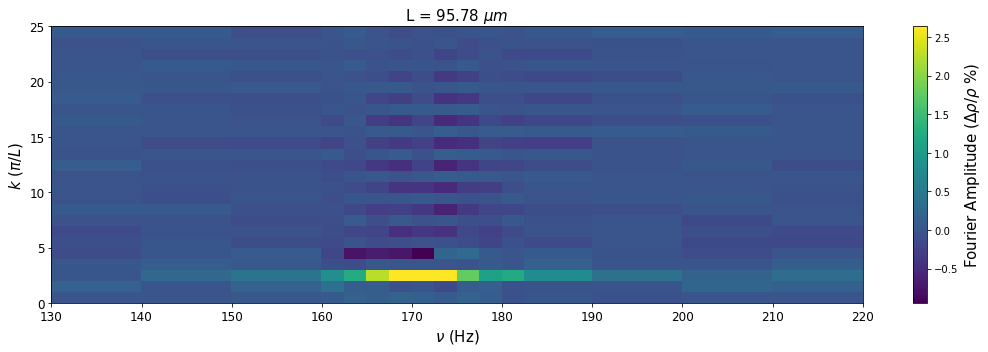

In [4844]:
# Compute FT 
kscale = np.pi/(Lum * 1.07)
k = np.arange(0, 25 * kscale, 1 * kscale)
ft = np.array([tp.fourier_transform(*c.trim(xlim=fit_zlim).plotdata, k)[1] for c in df_data['dn/n']]).T
ft *= 2 * kscale / np.pi
ft_real = [df_data.index.values, k/kscale, np.real(ft)]
ft_imag = [df_data.index.values, k/kscale, np.imag(ft)]
ft_abs = [df_data.index.values, k/kscale, np.abs(ft)]

sign = np.array([1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,])
sign = np.meshgrid(np.ones(ft.shape[1]), sign[:ft.shape[0]])[1]
mult = np.meshgrid(np.ones(ft.shape[1]), np.arange(ft.shape[0]))[1]
# ft = [df_data.index.values, k/kscale, ft_imag[2] * (mult%2) * sign + ft_real[2] * ((mult+1)%2) * sign]
ft = [df_data.index.values, k/kscale, ft_imag[2] * (mult%2) * sign + ft_real[2] * ((mult+1)%2) * sign]
if savefig.value: pd.DataFrame(ft[2], index=ft[1], columns=ft[0]).to_excel(suffix_ft + 'fourier_transform.xlsx')
    
# Plots 
clim_ft = np.max(np.abs(ft[2])) * 0.85
fig = plt.figure(figsize=[15, 5])
plt.pcolor(*movie_pad(ft), cmap='viridis', vmax=clim_ft, linewidth=0)
plt.ylabel(r'$k$ ($\pi/L$)', fontsize=15)
plt.xlabel(x_var_label, fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(Lum), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'Fourier Amplitude ($\Delta \rho / \rho$ %)', fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix_ft + 'FourierAmpsMovie_viridis.pdf')

In [4845]:
# Lorentzian Fit Info 
mode_num = np.array([2])
ref_freq_guess = 90
gamma_guess = mode_num * 20

fit_lims_width = [50, 50, 60, 120, 150, 240, ]
fit_lims = {'1' : [0, 120], '2':[90, 200], '3':[120, 320], '4':[150, 400], 
            '5':[100,700], '6' : [100, 1000], '7':[100,1000], '8':[100,1000],
            '9':[100,1000], '10':[100,1000]}
fit_lims = {}

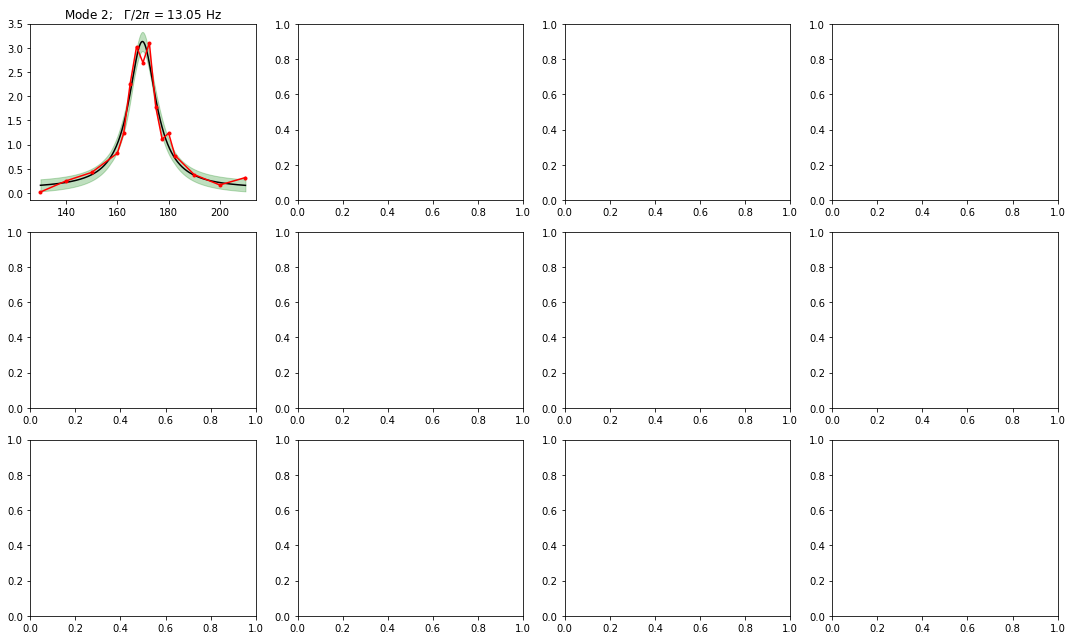

In [4846]:
# Lorentzian Fits 
mode_fits = []

for i,m in enumerate(mode_num):
    ki = np.argmin(np.abs(ft[1] - m))
    guess = dict(x0 = ref_freq_guess*m, gamma = gamma_guess[i], amp=1, offset=0)
    c = tp.Curve(ft[0], ft[2][m,:]).trim(xlim=fit_lims.get(str(mode_num[i]), [-np.inf, np.inf]))
    cf = tp.curve_fit(tp.lorentzian, guess, *c.data, plot=False, info=False)
    mode_fits.append(cf)

ax = plt.subplots(ncols=4, nrows=3, figsize=[15,9])[1].flatten()

for i,m in enumerate(mode_fits):
    m.plot_fiterrors(ax=ax[i])
    ax[i].set(title=r'Mode {};   $\Gamma/2\pi$ = {:.2f} Hz'.format(mode_num[i], abs(m['gamma'])))
plt.tight_layout()
if savefig.value: plt.savefig(suffix_ft + 'LorentzianFits.pdf')

In [4847]:
# Extract Data 
modes = pd.DataFrame()
modes['mode num'] = mode_num
modes['k (1/m)'] = mode_num * np.pi/Lum * 1e6
modes['k (1/m) error'] = 0
modes['f (Hz)'] = [cf['x0'] for cf in mode_fits]
modes['f (Hz) error'] = [cf.fe['x0'] for cf in mode_fits]
modes['f0 (Hz)'] = modes['f (Hz)'] / modes['mode num']
modes['f0 (Hz) error'] = modes['f (Hz) error'] / modes['mode num']
modes['w (1/s)'] = modes['f (Hz)'] * twopi
modes['w (1/s) error'] = modes['f (Hz) error'] * twopi
modes['c (m/s)'] = modes['w (1/s)'] / modes['k (1/m)']
modes['c (m/s) error'] = modes['w (1/s) error'] / modes['k (1/m)']
modes['gamma (Hz)'] = np.abs([cf['gamma'] for cf in mode_fits])
modes['gamma (Hz) error'] = [cf.fe['gamma'] for cf in mode_fits]
modes['gamma (1/s)'] = modes['gamma (Hz)'] * twopi
modes['gamma (1/s) error'] = modes['gamma (Hz) error'] * twopi
modes['FT amplitude (%)'] = [cf['amp'] for cf in mode_fits]
modes['FT amplitude (%) error'] = [cf.fe['amp'] for cf in mode_fits]
modes = modes.set_index('mode num', drop=False)

if savefig.value: modes.to_excel(suffix_ft + 'modes_results.xlsx')
modes

,mode num,k (1/m),k (1/m) error,f (Hz),f (Hz) error,f0 (Hz),f0 (Hz) error,w (1/s),w (1/s) error,c (m/s),c (m/s) error,gamma (Hz),gamma (Hz) error,gamma (1/s),gamma (1/s) error,FT amplitude (%),FT amplitude (%) error
mode num,,,,,,,,,,,,,,,,,
2,2,65601.084112,0,169.791513,0.381492,84.895757,0.190746,1066.831541,2.396986,0.016262,0.000037,13.050809,1.586274,82.000652,9.966852,3.053411,0.19848


In [4848]:
# # Plot Freq vs Mode Num 
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['mode num'], modes['f (Hz)'], modes['f (Hz) error'], fmt='bo')
# cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['mode num'], modes['f (Hz)'], modes['f (Hz) error'], info=False, plot=False)
# xp = np.linspace(0, modes['mode num'].max() + 0.4)
# plt.plot(xp, cf(xp), 'k-')
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.xlabel('Mode Number', fontsize=15)
# plt.ylabel(r'$\nu$ (Hz)', fontsize=15)
# plt.title(r'Fundamental Frequency {:.2f} $\pm$ {:.2f} Hz '.format(cf[0], cf.fe[0]), fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'FundamentalFrequency_v1.pdf')

# # Plot Freq vs Mode Num 
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], fmt='bo')
# cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], info=False, plot=False)
# dict_data['speed fit'] = cf
# xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
# plt.plot(xp, cf(xp), 'k-')
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
# plt.ylabel(r'$\omega$ (1/s)', fontsize=15)
# plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0]*1e-3, cf.fe[0]*1e-3), fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'Dispersion Relation_v1.pdf')

# # Plot Freq vs Mode Num 
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)']*1e-3, modes['w (1/s) error']*1e-3, fmt='bo')
# cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)']*1e-3, modes['w (1/s) error']*1e-3, info=False, plot=False)
# xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
# plt.plot(xp, cf(xp), 'k-')
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
# plt.ylabel(r'$\omega$ (1/ms)', fontsize=15)
# plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0], cf.fe[0]), fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'Dispersion Relation_v2.pdf')

# # Plot Gamma vs Freq 
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['f (Hz)'], modes['gamma (Hz)'], xerr=modes['f (Hz) error'], yerr=modes['gamma (Hz) error'], fmt='bo')
# plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
# plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.title(r'$\Gamma$ is FWHM', fontsize=15)
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'GammaVsOmega_v1.pdf')

# # Plot Gamma vs Omega with Linear Fit
# modes_ = modes.iloc[2:]
# cf = tp.curve_fit(lambda x, a1=0, a0=0: a0 + a1 * x, [1,0], modes_['f (Hz)'], modes_['gamma (Hz)'], modes_['gamma (Hz) error'], info=True)
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['f (Hz)'], modes['gamma (Hz)'], xerr=modes['f (Hz) error'], yerr=modes['gamma (Hz) error'], fmt='bo')
# xp = np.linspace(0, cf.x.max()*1.05, 100)
# plt.plot(xp, cf(xp), 'k-')
# plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
# plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.title(r'$\Gamma = {:.2f} \pm {:.2f} \: \omega - {:.2f}$'.format(cf[0], cf.fe[0], -cf[1]), fontsize=15)
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'GammaVsOmega_v2.pdf')
    
# # Plot Gamma vs Omega with Quadratic Fit 
# cf = tp.curve_fit(lambda x, a2=0: a2*x**2, [1], modes['w (1/s)'], modes['gamma (1/s)'], modes['gamma (1/s) error'], info=True)
# speed = dict_data['speed fit'][0] * 1e-6
# eta_rho = [3/4 * cf[0] * speed**2 * cst.mass / cst.hbar, 3/4 * cf.fe[0] * speed**2 * cst.mass / cst.hbar]
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['w (1/s)'], modes['gamma (1/s)'], xerr=modes['w (1/s) error'], yerr=modes['gamma (1/s) error'], fmt='bo')
# xp = np.linspace(0, cf.x.max()*1.05, 100)
# plt.plot(xp, cf(xp), 'k-')
# plt.xlabel(r'$\omega$ (1/s)', fontsize=15)
# plt.ylabel(r'$\Gamma$ (1/s)', fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.title(r'$\eta / \rho = {:.2f} \pm {:.2f} \: \hbar / m$'.format(*eta_rho), fontsize=15)
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'GammaVsOmega_v3.pdf')

# # Plot Q vs Freq 
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['f (Hz)'], modes['f (Hz)']/modes['gamma (Hz)'], xerr=modes['f (Hz) error'], 
#              yerr=np.sqrt((modes['f (Hz) error']/modes['gamma (Hz)'])**2 + (modes['gamma (Hz) error'] * modes['f (Hz)']/modes['gamma (Hz)']**2)**2), fmt='bo')
# plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
# plt.ylabel(r'Q = $\omega / \Gamma $', fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.title(r'$\Gamma$ is FWHM', fontsize=15)
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'QVsFreq_v1.pdf')

In [4849]:
# Copy the file 
if savefig.value:
    shutil.copyfile(getNotebookName(), suffix + 'BoxShakingAnalyzer.ipynb')

<IPython.core.display.Javascript object>

## Fitting Box Modes 

In [ ]:
shift = 0
if zero_z == 'center': shift -= Lum/2
elif zero_z == 'top': shift -= Lum
fit_zlim = (np.array([0 + 0, Lum - 0]))*1e-6 + shift*1e-6
xp = np.linspace(0, Lum, 100) + shift

In [ ]:
# Fitting with discrete box modes 
fit_keys = ['a{}'.format(i) for i in range(21)]
guess = {k:1 for k in fit_keys}
fixed = dict(L = Lum * 1.05, phase=0, )

def compute_ft_box_fits_v1(dn_n):
    cf = tp.curve_fit(discrete_modes_v3, guess, *dn_n.trim(xlim=fit_zlim).plotdata, fixed=fixed)
    return (np.array([[i,cf[k]] for i,k in enumerate(fit_keys)]).T, cf)

def temp(test = 32):
    r = df_data.iloc[test]
    c_fit = r['dn/n'].trim(xlim=fit_zlim)
    c_fit = tp.Curve(*c_fit.plotdata)
    ft, cf = compute_ft_box_fits_v1(r['dn/n'])
    # Plot 
    fig, ax = plt.subplots(ncols=2, figsize=[12,4])
    plt.sca(ax[0])
    plt.plot(*r['dn/n'].plotdata)
    plt.plot(xp, cf(xp))
    plt.axvspan(*fit_zlim*1e6, color='k', alpha=0.05)
    plt.axhline(0, c='k', alpha=0.3)
    plt.axvline(0, c='k', alpha=0.3)
    plt.xlim(plot_zlim)
    amp = np.max(np.abs(c_fit.y)) * 2
    plt.ylim([-amp, amp])
    plt.sca(ax[1])
    plt.bar(*ft)
    plt.tight_layout()
    plt.show()
    
    
    
if df_data.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_data.shape[0]-1))

In [ ]:
# Compute ft 
ft = [df_data.index.values, np.arange(len(fit_keys)), 
      np.array([compute_ft_box_fits_v1(c)[0][1] for c in tqdm(df_data['dn/n'])]).T]

# Plots 
clim_ft = np.max(np.abs(ft[2])) * 0.5
fig = plt.figure(figsize=[15, 5])
plt.pcolor(*movie_pad(ft), cmap='viridis', vmin=-clim_ft, vmax=clim_ft, linewidth=0)
plt.ylabel(r'$k$ ($\pi/L$)', fontsize=15)
plt.xlabel(x_var_label, fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(Lum), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'Fourier Amplitude ($\Delta \rho / \rho$ %)', fontsize=15)
plt.tight_layout()

In [ ]:
# Lorentzian Fit Info 
mode_num = np.array([1,2,3,4,5,6,7])
ref_freq_guess = 75
gamma_guess = mode_num * 10

fit_lims = {'1' : [0, 100], '2':[90, 200], '3':[130, 300], '4':[150, 500], '5':[200,600], '6' : [320, 560], '7':[200,700]}
fit_lims = {'1' : [0, 100], '2':[100, 200], '3':[130, 300], '4':[170, 500], }

In [ ]:
# Lorentzian Fits 
mode_fits = []

for i,m in enumerate(mode_num):
    ki = np.argmin(np.abs(ft[1] - m))
    guess = dict(x0 = ref_freq_guess*m, gamma = gamma_guess[i], amp=1,)
    c = tp.Curve(ft[0], ft[2][m,:]).trim(xlim=fit_lims.get(str(mode_num[i]), [-np.inf, np.inf]))
    cf = tp.curve_fit(tp.lorentzian, guess, *c.data, plot=False, info=False)
    mode_fits.append(cf)

# Slider plot 
def temp(test = 4):
    ax = mode_fits[test].plot(fiterrors=False)
    ax[0].set_title('mode num {}'.format(mode_num[test]))
    plt.sca(ax[0])
#     if savefig.value: plt.savefig(suffix + 'SampleFits_Mode{}.pdf'.format(mode_num[test]))
    plt.show()
w = ipywidgets.interact(temp, test=(0, len(mode_num)-1))

In [ ]:
# Extract Data 
modes = pd.DataFrame()
modes['mode num'] = mode_num
modes['k (1/m)'] = mode_num * np.pi/Lum * 1e6
modes['f (Hz)'] = [cf['x0'] for cf in mode_fits]
modes['f (Hz) error'] = [cf.fe['x0'] for cf in mode_fits]
modes['f0 (Hz)'] = modes['f (Hz)'] / modes['mode num']
modes['f0 (Hz) error'] = modes['f (Hz) error'] / modes['mode num']
modes['w (1/s)'] = modes['f (Hz)'] * twopi
modes['w (1/s) error'] = modes['f (Hz) error'] * twopi
modes['gamma (Hz)'] = np.abs([cf['gamma'] for cf in mode_fits])
modes['gamma (Hz) error'] = [cf.fe['gamma'] for cf in mode_fits]
modes['gamma (1/s)'] = modes['gamma (Hz)'] * twopi
modes['gamma (1/s) error'] = modes['gamma (Hz) error'] * twopi
modes['FT amplitude (arb.)'] = [cf['amp'] for cf in mode_fits]

modes

In [ ]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['mode num'], modes['f (Hz)'], modes['f (Hz) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['mode num'], modes['f (Hz)'], modes['f (Hz) error'], info=False, plot=False)
xp = np.linspace(0, modes['mode num'].max() + 0.4)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel('Mode Number', fontsize=15)
plt.ylabel(r'$\nu$ (Hz)', fontsize=15)
plt.title(r'Fundamental Frequency {:.2f} $\pm$ {:.2f} Hz '.format(cf[0], cf.fe[0]), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

In [ ]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], info=False, plot=False)
dict_data['speed fit'] = cf
xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
plt.ylabel(r'$\omega$ (1/s)', fontsize=15)
plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0]*1e-3, cf.fe[0]*1e-3), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

In [ ]:
# Plot Gamma vs Freq 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['f (Hz)'], modes['gamma (Hz)'], xerr=modes['f (Hz) error'], yerr=modes['gamma (Hz) error'], fmt='bo')
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma$ is FWHM', fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()

## Fitting Box Modes - SHGs only

# Spatial Decay

In [ ]:
# Cycle Selector 
_speed = 20e-3
_length = 80e-6
_freq = np.arange(450, 1300, 100)
_cycles = _length / _speed * _freq
for f,c in zip(_freq, _cycles): print('{} -- {:.2f}'.format(f, c))

In [ ]:
# Start a figure folder 
display(savefig)
suffix_sd = os.path.join(folder_name, 'Spatial Decay','')
os.makedirs(os.path.join(suffix_sd), exist_ok=True)
suffix_sd

In [ ]:
# Dataset Info 
speed_sound_guess = 15 * 1e-3
fit_lims = np.array([14, 76])
plot_lims = np.array([-10, 100])
fit_lims_range_ends = [[10, 30], [60, 80]]

In [ ]:
# Function Definitions 
def sin_decay(x, wavelength=1, kappa=0, amplitude=1, phase=0, a0=0, a1=0, a2=0):
    return amplitude * np.exp(- x * kappa) * np.sin(((twopi/wavelength)**2 - (kappa)**2)**(1/2) * x - phase) + a0 + a1*x + a2*x**2

In [ ]:
# Prepare for fit 
df_data['fitres'] = None
df_data['fit_guess'] = [dict(wavelength = [speed_sound_guess / r.freq * 1e6, r'$\mu m$', [5, 50]], 
                             kappa = [0.03, r'1/$\mu m$', [0, 0.15]], 
                             amplitude = [2.5, '%', [0, 20]], phase = [0, 'rad'],) 
                        for n,r in df_data.iterrows()]
df_data['fit_fixed'] = [dict() for n,r in df_data.iterrows()]

# Override guess for specific dataset 
# df_data.loc[600, 'fit_guess']['a0'] = 0.1

# Remove some data points 
df_data['use'] = True
# df_data.loc[900, 'use'] = True

In [ ]:
# Fit and plot 
use = 'dn/n'
test=np.random.randint(0, df_data.shape[0])

def temp_range(test=test, fl1=fit_lims[0], fl2=fit_lims[1], ax=None):
    r = df_data.iloc[test]
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    fit_lims_range = [np.arange(*fit_lims_range_ends[0], c.dx), np.arange(*fit_lims_range_ends[1], c.dx)]
    fitres_range = []
    for fl in fit_lims_range[0]:
        cf = tp.curve_fit(sin_decay, r.fit_guess, *c.trim(xlim=[fl, fl2]).data, fixed=r.fit_fixed)
        fitres_range.append([fl, cf.fv['wavelength'], cf.fe['wavelength'], cf.fv['kappa'], cf.fe['kappa'],
                             np.abs(cf.fv['amplitude']), cf.fe['amplitude'], cf.fv['phase'], cf.fe['phase']])
    for fl in fit_lims_range[1]:
        cf = tp.curve_fit(sin_decay, r.fit_guess, *c.trim(xlim=[fl1, fl]).data, fixed=r.fit_fixed)
        fitres_range.append([fl, cf.fv['wavelength'], cf.fe['wavelength'], cf.fv['kappa'], cf.fe['kappa'],
                             np.abs(cf.fv['amplitude']), cf.fe['amplitude'], cf.fv['phase'], cf.fe['phase']])
    fr = np.array(fitres_range).T
    if ax is not None:
        # Plot wavleength 
        ax[0].errorbar(fr[0], fr[1], fr[2], fmt='bo')
        ax[0].axhline(np.mean(fr[1]), color='b', alpha=0.5)
        ax[0].axhline(np.mean(fr[1]) * 0.95, color='b', alpha=0.5, linestyle='--', label=r'$\pm$ 5%')
        ax[0].axhline(np.mean(fr[1]) * 1.05, color='b', alpha=0.5, linestyle='--')
        ax[0].legend(loc=0, fontsize=12)
        ax[0].set(ylabel=r'Wavelength ($\mu m$)')
        
        ax[1].errorbar(fr[0], fr[3], fr[4], fmt='ro')
        ax[1].axhline(np.mean(fr[3]), color='r', alpha=0.5)
        ax[1].axhline(np.mean(fr[3]) * 0.85, color='r', alpha=0.5, linestyle='--', label=r'$\pm$ 15%')
        ax[1].axhline(np.mean(fr[3]) * 1.15, color='r', alpha=0.5, linestyle='--')
        ax[1].legend(loc=0, fontsize=12)
        ax[1].set(ylabel=r'$\kappa$ ($1 /\mu m$)')
        
        ax[2].errorbar(fr[0], fr[5], fr[6], fmt='bo')
        ax[2].axhline(np.mean(fr[5]), color='b', alpha=0.5)
        ax[2].axhline(np.mean(fr[5]) * 0.85, color='b', alpha=0.5, linestyle='--', label=r'$\pm$ 15%')
        ax[2].axhline(np.mean(fr[5]) * 1.15, color='b', alpha=0.5, linestyle='--')
        ax[2].legend(loc=0, fontsize=12)
        ax[2].set(ylabel=r'Amplitude $\Delta \rho / \rho$ (%)')
        
        ax[3].errorbar(fr[0], fr[7], fr[8], fmt='ro')
        ax[3].axhline(np.mean(fr[7]), color='r', alpha=0.5)
        ax[3].axhline(np.mean(fr[7]) * 0.85, color='r', alpha=0.5, linestyle='--', label=r'$\pm$ 15%')
        ax[3].axhline(np.mean(fr[7]) * 1.15, color='r', alpha=0.5, linestyle='--')
        ax[3].legend(loc=0, fontsize=12)
        ax[3].set(ylabel=r'phase (rad)')
        
    return fr


def temp_plot(test=test, fl1=fit_lims[0], fl2=fit_lims[1], amp=0):
    # Load Data 
    r = df_data.iloc[test]
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    xp = np.linspace(plot_lims[0], plot_lims[1], 1000)
    
    # Plot figure 
    fig = plt.figure(figsize=[10, 10])
    ax = []
    ax.append(plt.subplot2grid([3,1], [0,0],))
    ax.append(plt.subplot2grid([3,2], [1,0],))
    ax.append(plt.subplot2grid([3,2], [1,1],))
    ax.append(plt.subplot2grid([3,2], [2,0],))
    ax.append(plt.subplot2grid([3,2], [2,1],))
    
    # Compute cf at given [fl1, fl2]
    cf = tp.curve_fit(sin_decay, r.fit_guess, *c.trim(xlim=[fl1, fl2]).data, fixed=r.fit_fixed)
    
    # Plots 
    plt.sca(ax[0])
    plt.plot(xp, cf(xp), 'C1')
    plt.plot(*c.plotdata, '.-C0')
    plt.axvline(0, c='k', linestyle='--', )
    plt.axvline(r.length*1e6, c='k', linestyle='--', )
    plt.axhline(0, c='k', linestyle='-', alpha=0.5)
    plt.axvspan(fl1, fl2, alpha=0.05, color='k', label='Fourier Width')
    plt.plot(c.x, cf(c.x, amplitude=0), 'C2-', alpha=0.5)
    amp_ = abs(cf['amplitude']) * 1.5
    amp_ += abs(cf(np.array([0]), phase=np.pi/2)[0])
    if amp_ >= 10: amp_ = 9.99
    if amp == 0.0: amp = amp_
    plt.ylim([-amp, amp])
    plt.xlim(plot_lims)
    plt.xlabel(r'z ($\mu m$)', fontsize=12)
    plt.ylabel(r'$\Delta \rho / \rho$ (%)', fontsize=12)
    plt.title("{} = {}".format(x_var_label, r.name), fontsize=12)
    
    # Compute range of fits 
    fr = temp_range(test, fl1, fl2, ax=ax[1:])
    
    plt.tight_layout()
    plt.show()
    if savefig.value: fig.savefig(suffix_samples + 'SpatialDecayFit-{}.pdf'.format(r.name))
    
if df_data.shape[0] == 1: temp_plot(0, True, 0)
else: ipywidgets.interact(temp_plot, test=(0, df_data.shape[0]-1), amp=(0, 20, 1), fl1=(0, 40, 2), fl2=(50, 96, 2))

In [ ]:
# Fit all and raw plot 
for n,r in df_data.iterrows():
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    df_data.loc[r.name, 'fitres'] = tp.curve_fit(sin_decay, r.fit_guess, *c.trim(xlim=fit_lims).data, fixed=r.fit_fixed)

# Fix phase and amp 
for n,r in df_data.iterrows():
    if r.fitres['amplitude'] < 0:
        r.fitres.fr.loc['amplitude','FitValue'] = - r.fitres['amplitude']
        r.fitres.fr.loc['phase','FitValue'] = r.fitres['phase'] + np.pi
    r.fitres.fr.loc['phase','FitValue'] = np.mod(r.fitres.fr.loc['phase','FitValue'], twopi)

# Plot 
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[20,10], sharex=True)
fn_ = df_data.iloc[0].fitres.fr.index.values
fu_ = df_data.iloc[0].fitres.fr['Units'].values
ax = ax.flatten()
for i in range(6):
    ax[i].errorbar(df_data[df_data.use].index.values, [fr.fv[i] for fr in df_data[df_data.use].fitres], [fr.fe[i] for fr in df_data[df_data.use].fitres], fmt='bo')
    ax[i].errorbar(df_data[~df_data.use].index.values, [fr.fv[i] for fr in df_data[~df_data.use].fitres], [fr.fe[i] for fr in df_data[~df_data.use].fitres], fmt='ro')
    ax[i].set_ylabel("{} ({})".format(fn_[i], fu_[i]), fontsize=15)
    ax[i].set_xlabel(x_var_label, fontsize=15)
    ax[i].grid()
plt.tight_layout()
if savefig.value: fig.savefig(suffix_sd + 'RawFits-v1.pdf')

In [ ]:
# Compute Fit results 
decay = pd.DataFrame(index = df_data.index.values)
decay['x'] = df_data.index.values
decay['x error'] = df_data.index.values * 0
decay['frequency (Hz)'] = df_data.freq.values
decay['frequency (Hz) error'] = df_data.freq.values * 0
decay['omega (1/s)'] = decay['frequency (Hz)'] * twopi
decay['omega (1/s) error'] = decay['frequency (Hz) error'] * twopi
decay['omega (1/ms)'] = decay['omega (1/s)'] * 1e-3
decay['omega (1/ms) error'] = decay['omega (1/s) error'] * 1e-3
decay['wavelength (um)'] = [fr.fv['wavelength'] for fr in df_data.fitres]
decay['wavelength (um) error'] = [fr.fe['wavelength'] for fr in df_data.fitres]
decay['wavelength (m)'] = decay['wavelength (um)'] * 1e-6
decay['wavelength (m) error'] = decay['wavelength (um) error'] * 1e-6
decay['k (1/m)'] = twopi / decay['wavelength (m)']
decay['k (1/m) error'] = twopi * decay['wavelength (m) error'] / decay['wavelength (m)']**2
decay['k (1/um)'] = decay['k (1/m)'] * 1e-6
decay['k (1/um) error'] = decay['k (1/m) error'] * 1e-6
decay['speed (m/s)'] = decay['wavelength (m)'] * decay['frequency (Hz)']
decay['speed (m/s) error'] = decay['wavelength (m) error'] * decay['frequency (Hz)']
decay['speed (mm/s)'] = decay['speed (m/s)'] * 1e3
decay['speed (mm/s) error'] = decay['speed (m/s) error'] * 1e3
decay['kappa (1/um)'] = [fr.fv['kappa'] for fr in df_data.fitres]
decay['kappa (1/um) error'] = [fr.fe['kappa'] for fr in df_data.fitres]
decay['kappa (1/m)'] = decay['kappa (1/um)'] * 1e6
decay['kappa (1/m) error'] = decay['kappa (1/um) error'] * 1e6
decay['gamma (1/s)'] = 2 * decay['speed (m/s)'] * decay['kappa (1/m)']
decay['gamma (1/s) error'] = 2 * np.sqrt((decay['speed (m/s) error'] * decay['kappa (1/m)'])**2 + (decay['speed (m/s)'] * decay['kappa (1/m) error'])**2)
decay['gamma (Hz)'] = decay['gamma (1/s)'] / twopi
decay['gamma (Hz) error'] = decay['gamma (1/s) error'] / twopi
decay['amplitude (%)'] = [fr.fv['amplitude'] for fr in df_data.fitres]
decay['amplitude (%) error'] = [fr.fe['amplitude'] for fr in df_data.fitres]

# Save Data to Excel 
if savefig.value: decay.to_excel(suffix_sd + 'SpatialDecay-Data.xlsx')
# print(decay.iloc[0])
decay.head(2)

## Amplitude Dependence

In [ ]:
# Main Plot 
keys = ['amplitude (%)', 'gamma (Hz)']
xyz = [decay[keys[0]].values, decay[keys[1]].values, decay[keys[1] + ' error'].values]
cf = tp.curve_fit(lambda x, a1=0, a0=0: a1*x + a0, [1,1], *xyz, info=True)
fig,ax = plt.subplots(figsize=[7,6])
plt.errorbar(*xyz, xerr=decay[keys[0] + ' error'], fmt = 'bo')
xp = np.linspace(0, np.max(xyz[0])* 1.1, )
plt.plot(xp, cf(xp), 'k--', label=r'{:.2f} + {:.2f} x'.format(cf['a0'], cf['a1']))
plt.xlabel(r'$\Delta \rho / \rho$ (%)', fontsize=15)
plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
plt.title(r'Amplitude Response of Spatial Decay at {} Hz'.format(decay['frequency (Hz)'].iloc[0]), fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: fig.savefig(suffix_sd + 'GammaVsAmp_v1.pdf')

In [ ]:
# Main Plot 
keys = ['amplitude (%)', 'speed (mm/s)']
xyz = [decay[keys[0]].values, decay[keys[1]].values, decay[keys[1] + ' error'].values]
cf = tp.curve_fit(lambda x, a0=0: x*0 + a0, [1,], *xyz, info=True)
fig,ax = plt.subplots(figsize=[7,6])
plt.errorbar(*xyz, xerr=decay[keys[0] + ' error'], fmt = 'bo')
xp = np.linspace(0, np.max(xyz[0])* 1.1, )
plt.plot(xp, cf(xp), 'k--')
plt.xlabel(r'$\Delta \rho / \rho$ (%)', fontsize=15)
plt.ylabel(r'$c$ (mm/s)', fontsize=15)
plt.title(r'Amplitude Response of Spatial Decay at {} Hz'.format(decay['frequency (Hz)'].iloc[0]), fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.xlim([0, None])
perc = 10/100
plt.ylim([cf['a0'] * (1-perc), cf['a0'] * (1+perc)])
plt.tight_layout()
if savefig.value: fig.savefig(suffix_sd + 'SpeedVsAmp_v1.pdf')

In [ ]:
# Plot overlaping profiles 


## Frequency Dependence

In [ ]:
# Main Plot 
keys = ['frequency (Hz)', 'gamma (Hz)']
xyz = [decay[keys[0]].values, decay[keys[1]].values, decay[keys[1] + ' error'].values]
fig,ax = plt.subplots(figsize=[7,6])
plt.errorbar(*xyz, xerr=decay[keys[0] + ' error'], fmt = 'bo')
xp = np.linspace(0, np.max(xyz[0])* 1.1, )
cf2 = tp.curve_fit(lambda x, a2=0: x**2 * a2, [1,], *xyz, info=True)
eta_rho = [3/4 * cst.mass / cst.hbar * cf2.fv[0] /twopi * np.mean(decay['speed (m/s)'])**2, 
          3/4 * cst.mass / cst.hbar * cf2.fe[0] /twopi * np.mean(decay['speed (m/s)'])**2]
plt.plot(xp, cf2(xp), 'k--', label=r'$\eta / \rho = {:.2f} \pm {:.2f} \: \hbar/m$'.format(*eta_rho))
cf1 = tp.curve_fit(lambda x, a1=0, a0=0: x * a1 + a0, [1,1], *xyz, info=True)
plt.plot(xp, cf1(xp), 'r--')
plt.xlabel(r'$\omega / 2 \pi$ (Hz)', fontsize=15)
plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
plt.title(r'Frequency Response of Spatial Decay', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.xlim([0, None])
perc = 10/100
# plt.ylim([cf['a0'] * (1-perc), cf['a0'] * (1+perc)])
plt.tight_layout()

In [ ]:
# Dispersion Relation 
keys = ['k (1/um)', 'omega (1/ms)']
xyz = [decay[keys[0]].values, decay[keys[1]].values, decay[keys[1] + ' error'].values]
fig,ax = plt.subplots(figsize=[7,6])
plt.errorbar(*xyz, xerr=decay[keys[0] + ' error'], fmt = 'bo')
xp = np.linspace(0, np.max(xyz[0])* 1.1, )
cf = tp.curve_fit(lambda x, a1=0, a0=0: x * a1 + a0, [1,], *xyz[0:2], info=True)
plt.plot(xp, cf(xp), 'r-')
plt.xlabel(r'$k$ $(1/\mu m)$', fontsize=15)
plt.ylabel(r'$\omega$ $(1/ms)$', fontsize=15)
plt.title(r'Frequency Response of Spatial Decay', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()

## Temperature Dependence

In [ ]:
# Main Plot 
keys = ['x', 'speed (mm/s)']
xyz = [decay[keys[0]].values, decay[keys[1]].values, decay[keys[1] + ' error'].values]
fig,ax = plt.subplots(figsize=[7,6])
plt.errorbar(*xyz, xerr=decay[keys[0] + ' error'], fmt = 'bo')
xp = np.linspace(0, np.max(xyz[0])* 1.1, )
plt.xlabel(r'Heat Cycles', fontsize=15)
plt.ylabel(r'c (mm/s)', fontsize=15)
plt.title(r'Frequency Response of Spatial Decay', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.xlim([0, None])
perc = 10/100
# plt.ylim([cf['a0'] * (1-perc), cf['a0'] * (1+perc)])
plt.tight_layout()

# Energy Expansion